In [45]:
import numpy as np
import scipy.stats as si
import scipy.stats.mstats
import pandas as pd
import math
import matplotlib.pyplot as plt
from torch.quasirandom import SobolEngine
from keras.utils import np_utils
from scipy.interpolate import interp1d
plt.style.use('seaborn')
import warnings

In [46]:
def BlackScholesExactSimulation(S, dts, r, sigma, numPath):
    out = []
    W = []
    
    if isinstance(S, np.ndarray) and len(S) == numPath:
        currentPath = S
    else:
        currentPath = np.ones(numPath) * S
        
    out.append(np.array(currentPath))

    for i in range(len(dts)-1):
        wPath = np.random.normal(0,1, int(numPath / 2))
        wPath = np.array([wPath, -wPath]).flatten()
        avgVar = np.var(wPath)
        wPath /= np.sqrt(avgVar)
        W.append(np.array(wPath))
        dt = dts[i+1]-dts[i]
        currentPath *= np.exp((r - (sigma * sigma * 0.5))*dt + sigma * math.sqrt(dt) * wPath)
        out.append(np.array(currentPath))
    return (out, W)


def BlackScholesExactSimulationSobol(S, dts, r, sigma, numPath, scramble=True):
    out = []
    W = []
    
    if isinstance(S, np.ndarray) and len(S) == numPath:
        currentPath = S
    else:
        currentPath = np.ones(numPath) * S
        
    out.append(np.array(currentPath))

    engine = SobolEngine(len(dts)-1, scramble=scramble, seed=None)
    totalW = si.norm.ppf(np.array(engine.draw(numPath))*(1-2e-7)+1e-7)

    for i in range(len(dts)-1):
        wPath = totalW[:,i]
        wPath -= np.average(wPath)
        wPath /= np.sqrt(np.var(wPath))
        W.append(np.array(wPath))
        dt = dts[i+1]-dts[i]
        currentPath *= np.exp((r - (sigma * sigma * 0.5))*dt + sigma * math.sqrt(dt) * wPath)
        out.append(np.array(currentPath))
    return (out, W)

def PriceEuroVanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

def PriceEuroVanillaDelta(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result =  - si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

In [47]:
S0 = 1.0
dts = [0.0, 0.5, 1.0]
r = 0.0
sigma = 0.25
numPath = 10000

(S, W) = BlackScholesExactSimulation(S0, dts, r, sigma, numPath)
S = np.array(S)

In [48]:
def policy(params, S):
    numPath = np.array(S).shape[1]
    action = [] 
    action.append(params[0] * np.ones(numPath))
    action.append(params[1] * np.ones(numPath) + params[2] * S[1] + params[3] * S[1]**2 )
    return action

def policyByPoints(params, S):
    numPath = np.array(S).shape[1]
    action = [] 
    action.append(params[0] * np.ones(numPath))
    p = [5.0, 25.0, 50.0, 75.0, 95.0]
    p_tile = np.percentile(S[1], p)
    action.append(interp1d(p_tile, params[1:6], kind='cubic', fill_value='extrapolate')(S[1]))
    return action

def policyByPointsAsymtotic(params, S):
    numPath = np.array(S).shape[1]
    points = params[1:6]
    action = [] 
    action.append(params[0] * np.ones(numPath))
    p = [5.0, 25.0, 50.0, 75.0, 95.0]
    p_tile = np.append(np.percentile(S[1], p), [0.5*np.min(S[1]), 2.0*np.max(S[1])])
    points = np.append(points, [0.0, 1.0])
    action.append(interp1d(p_tile, points, kind='cubic', fill_value='extrapolate')(S[1]))
    return action
    

In [49]:
def objVariance(params, S, payoff, l=0):
    action = policy(params, S)
    diff0 = S[1] - S[0]
    diff1 = S[2] - S[1]
    residual = payoff - action[0] * diff0 - action[1] * diff1
    return np.var(residual) - l*np.mean(residual)

def objVarianceByPoints(params, S, payoff, l=0):
    action = policyByPoints(params, S)
    diff0 = S[1] - S[0]
    diff1 = S[2] - S[1]
    residual = payoff - action[0] * diff0 - action[1] * diff1
    return np.var(residual) - l*np.mean(residual)

def objVarianceByPointsAsymtotic(params, S, payoff, l=0):
    action = policyByPointsAsymtotic(params, S)
    diff0 = S[1] - S[0]
    diff1 = S[2] - S[1]
    residual = payoff - action[0] * diff0 - action[1] * diff1
    return np.var(residual) - l*np.mean(residual)

In [50]:
optimalParams

array([ 5.59630815e-01, -3.82460273e+00,  6.64286649e-02, -2.25365554e-04])

         Current function value: 19.922151
         Iterations: 6
         Function evaluations: 206
         Gradient evaluations: 39
Var Explained Full   = 88.47
Var Explained Single = 79.07
Var Explained BS     = 88.28
PNL Full             = 7.9608
PNL Single           = 7.9622
PNL BS               = 7.962
P-Measure Price      = 7.9625
BS Price             = 7.9656
P-Measure t0 Hedge   = -0.0002
P-Measure t1 Hedge   = 0.0018


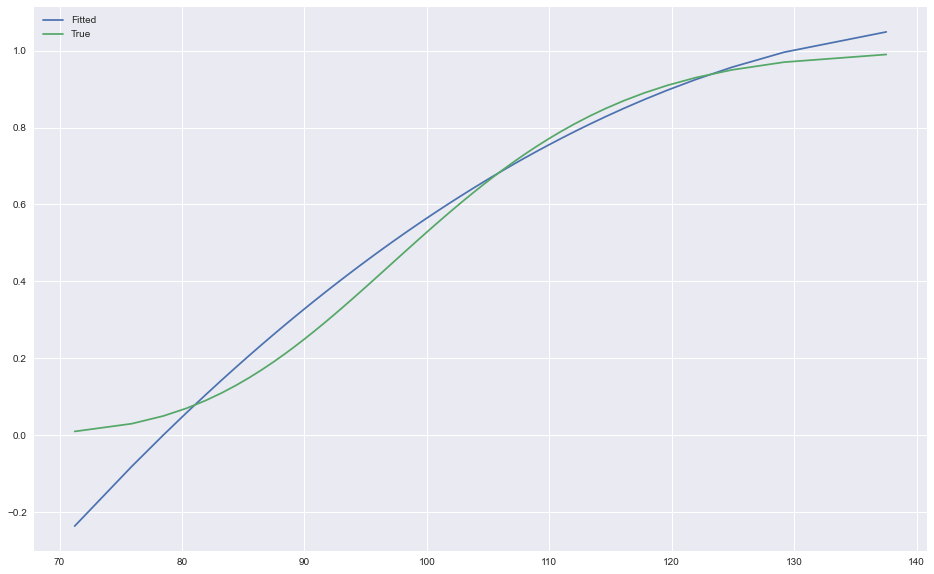

In [51]:
S0 = 100.0
dts = [0.0, 0.5, 1.0]
r = 0.0
d = 0.0
sigma = 0.2
numPath = 20000

(S, W) = BlackScholesExactSimulationSobol(S0, dts, r + d, sigma, numPath, scramble=False)
S = np.array(S)

params = [0.5, 0.1, 0.1, 0.1]
K = 100.0
payoff = np.maximum(S[2]-K, 0.0)
optimalParams= fmin_bfgs(objVariance, params, args=(S, payoff))

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S[1],sp)
aug_sp = (sp,sp,sp)

plt.figure(figsize=[16,10])
optimalPolicy = policy(optimalParams, aug_sp)
plt.plot(sp, optimalPolicy[1], label='Fitted')
plt.plot(sp, PriceEuroVanillaDelta(sp, K, dts[2]-dts[1], r, sigma), label='True')
plt.legend()

optimalPolicy = policy(optimalParams, S)
diff0 = S[1] - S[0]
diff1 = S[2] - S[1]
diffWhole= S[2] - S[0]
residual = payoff - optimalPolicy[0] * diff0 - optimalPolicy[1] * diff1
residualWhole = payoff - optimalPolicy[0] * diffWhole 

delta = PriceEuroVanillaDelta(S[1], K, dts[2], r, sigma)
residualDelta = payoff - optimalPolicy[0] * diff0 - delta * diff1

print("Var Explained Full   = " + str(round((1.0 - (np.var(residual) / np.var(payoff))) * 100.0, 2)))
print("Var Explained Single = " + str(round((1.0 - (np.var(residualWhole) / np.var(payoff))) * 100.0, 2)))
print("Var Explained BS     = " + str(round((1.0 - (np.var(residualDelta) / np.var(payoff))) * 100.0, 2)))

print("PNL Full             = " + str(round(np.mean(residual) , 4)))
print("PNL Single           = " + str(round(np.mean(residualWhole) , 4)))
print("PNL BS               = " + str(round(np.mean(residualDelta) , 4)))

print("P-Measure Price      = " + str(round(np.mean(payoff),4)))
print("BS Price             = " + str(round(PriceEuroVanilla(S0, K, 1.0, r, sigma), 4)))

print("P-Measure t0 Hedge   = " + str(round(np.mean(diff0 * optimalPolicy[0]),4)))
print("P-Measure t1 Hedge   = " + str(round(np.mean(diff1 * optimalPolicy[1]),4)))

(7.960824270994148, 7.9622334734200315)

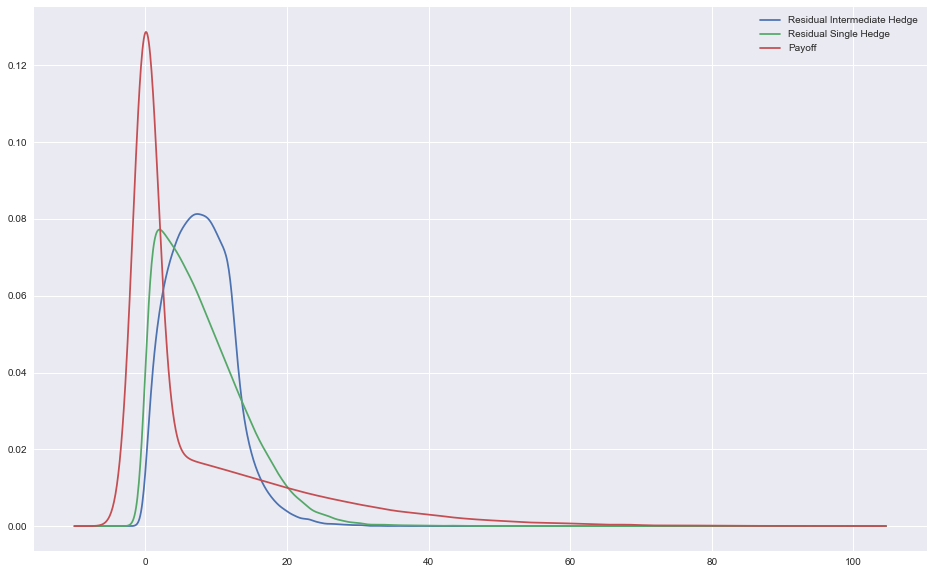

In [52]:
from scipy.stats import gaussian_kde

diff0 = S[1] - S[0]
diff1 = S[2] - S[1]
diffWhole= S[2] - S[0]
residual = payoff - optimalPolicy[0] * diff0 - optimalPolicy[1] * diff1
residualWhole = payoff - optimalPolicy[0] * diffWhole

bins = np.arange(-10, np.max(payoff), 0.1)

kernel_r = gaussian_kde(residual)
kernel_w = gaussian_kde(residualWhole)
kernel_p = gaussian_kde(payoff)
scores_r = kernel_r(bins)
scores_p = kernel_p(bins)
scores_w = kernel_w(bins)

plt.figure(figsize=[16,10])
plt.plot(bins, scores_r, label='Residual Intermediate Hedge')
plt.plot(bins, scores_w, label='Residual Single Hedge')
plt.plot(bins, scores_p, label='Payoff')

plt.legend()

np.mean(residual), np.mean(residualWhole)

In [53]:
(1.0 - (np.var(residual) / np.var(payoff))) * 100.0

88.46808760195867

In [54]:
(1.0 - (np.var(residualWhole) / np.var(payoff))) * 100.0

79.06986527529514

Optimization terminated successfully.
         Current function value: -37.136752
         Iterations: 11
         Function evaluations: 128
         Gradient evaluations: 16
Var Explained Full   = 91.55
Var Explained Single = 83.2
Var Explained BS     = 91.1
PNL Full             = 7.9649
PNL Single           = 8.091
PNL BS               = 8.0879
P-Measure Price      = 10.9839
BS Price             = 7.9656
P-Measure t0 Hedge   = 1.4281
P-Measure t1 Hedge   = 1.5909


(7.965567455405804, 7.964909399776018, 8.087864013303754, 10.983894292356814)

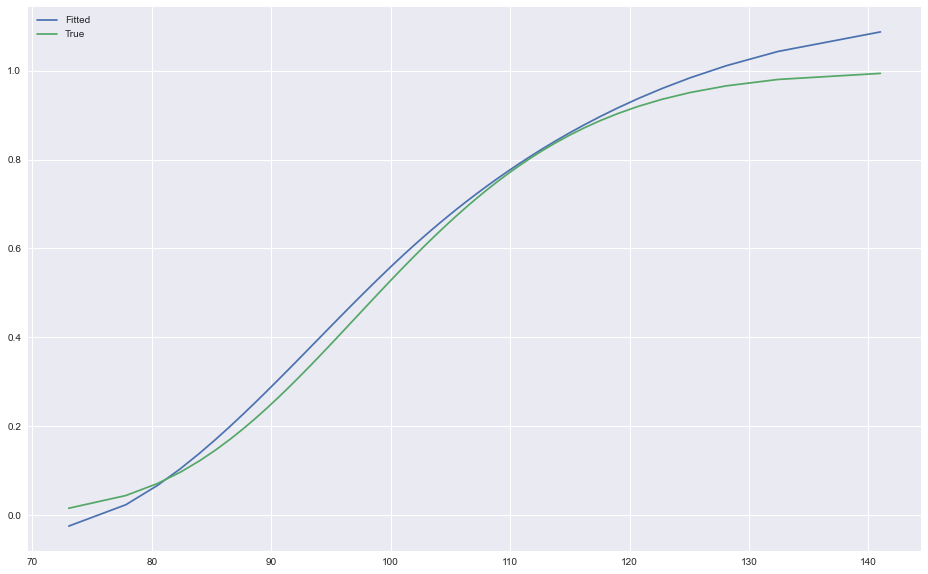

In [55]:
from scipy.optimize import fmin_bfgs

S0 = 100.0
T = 1.0
dts = [0.0, 0.5, T]
r = 0.0
d = 0.05
sigma = 0.2
numPath = 20000
l = 7.2
#l = 15.0 gives risk netural

(S, W) = BlackScholesExactSimulationSobol(S0, dts, r + d, sigma, numPath, scramble=False)
S = np.array(S)

params = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
K = 100.0
payoff = np.maximum(S[2]-K, 0.0)
optimalParams= fmin_bfgs(objVarianceByPoints, params, args=(S, payoff, l))

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S[1],sp)
aug_sp = (sp,sp,sp)
    
plt.figure(figsize=[16,10])
optimalPolicy_sp = policyByPoints(optimalParams, aug_sp)
plt.plot(sp, optimalPolicy_sp[1], label='Fitted')
plt.plot(sp, PriceEuroVanillaDelta(sp, K, T-0.5, 0.0, sigma), label='True')
plt.legend()

optimalPolicy = policyByPoints(optimalParams, S)
diff0 = S[1] - S[0]
diff1 = S[2] - S[1]
diffWhole= S[2] - S[0]

residual = payoff - optimalPolicy[0] * diff0 - optimalPolicy[1] * diff1
residualWhole = payoff - optimalPolicy[0] * diffWhole

delta0 = PriceEuroVanillaDelta(S0, K, T, r, sigma)
delta = PriceEuroVanillaDelta(S[1], K, T - 0.5, 0.0, sigma)
residualDelta = payoff - delta0 * diff0 - delta * diff1

print("Var Explained Full   = " + str(round((1.0 - (np.var(residual) / np.var(payoff))) * 100.0, 2)))
print("Var Explained Single = " + str(round((1.0 - (np.var(residualWhole) / np.var(payoff))) * 100.0, 2)))
print("Var Explained BS     = " + str(round((1.0 - (np.var(residualDelta) / np.var(payoff))) * 100.0, 2)))

print("PNL Full             = " + str(round(np.mean(residual) , 4)))
print("PNL Single           = " + str(round(np.mean(residualWhole) , 4)))
print("PNL BS               = " + str(round(np.mean(residualDelta) , 4)))

print("P-Measure Price      = " + str(round(np.mean(payoff),4)))
print("BS Price             = " + str(round(PriceEuroVanilla(S0, K, T, r, sigma), 4)))

print("P-Measure t0 Hedge   = " + str(round(np.mean(diff0 * optimalPolicy[0]),4)))
print("P-Measure t1 Hedge   = " + str(round(np.mean(diff1 * optimalPolicy[1]),4)))

PriceEuroVanilla(S0, K, 1.0, r, sigma), np.mean(residual), np.mean(residualDelta), np.mean(payoff)

Optimization terminated successfully.
         Current function value: 19.558909
         Iterations: 10
         Function evaluations: 112
         Gradient evaluations: 16
Var Explained Full   = 88.69
Var Explained Single = 79.09
Var Explained BS     = 88.62
PNL Full             = 7.9649
PNL Single           = 7.9652
PNL BS               = 7.965
P-Measure Price      = 7.965
BS Price             = 7.9656
P-Measure t0 Hedge   = -0.0
P-Measure t1 Hedge   = 0.0001


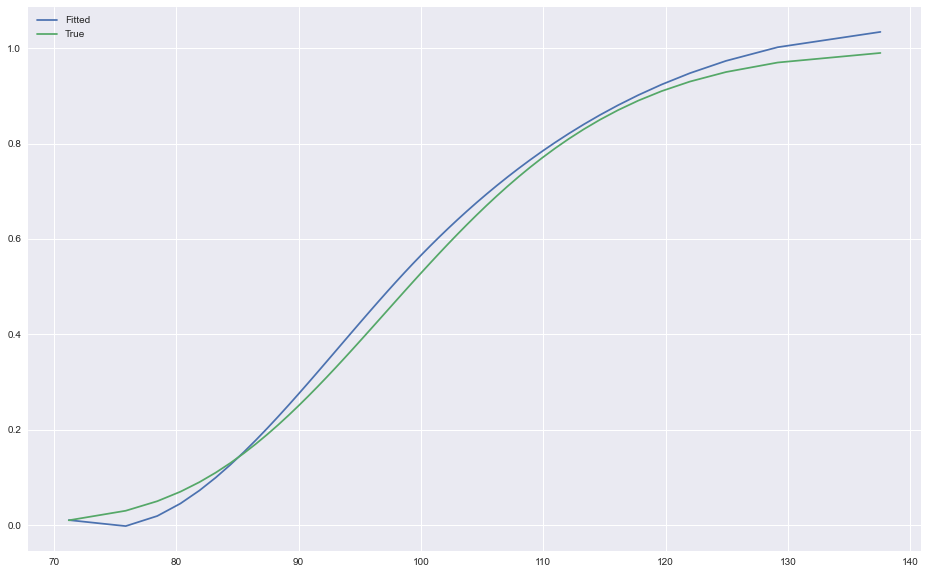

In [60]:
from scipy.optimize import fmin_bfgs

S0 = 100.0
dts = [0.0, 0.5, 1.0]
r = 0.0
d = 0.0
sigma = 0.2
numPath = 20000
l = 0.0

(S, W) = BlackScholesExactSimulationSobol(S0, dts, r + d, sigma, numPath, scramble=True)
S = np.array(S)

params = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
K = 100.0
payoff = np.maximum(S[2]-K, 0.0)
optimalParams= fmin_bfgs(objVarianceByPoints, params, args=(S, payoff, l))

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S[1],sp)
aug_sp = (sp,sp,sp)
    
plt.figure(figsize=[16,10])
optimalPolicyRN_sp = policyByPoints(optimalParams, aug_sp)
plt.plot(sp, optimalPolicyRN_sp[1], label='Fitted')
plt.plot(sp, PriceEuroVanillaDelta(sp, K, 0.5, r, sigma), label='True')
plt.legend()

optimalPolicy = policyByPoints(optimalParams, S)
diff0 = S[1] - S[0]
diff1 = S[2] - S[1]
diffWhole= S[2] - S[0]

residual = payoff - optimalPolicy[0] * diff0 - optimalPolicy[1] * diff1
residualWhole = payoff - optimalPolicy[0] * diffWhole

delta0 = PriceEuroVanillaDelta(S0, K, 1.0, 0.0, sigma)
delta = PriceEuroVanillaDelta(S[1], K, 0.5, 0.0, sigma)
residualDelta = payoff - delta0 * diff0 - delta * diff1

print("Var Explained Full   = " + str(round((1.0 - (np.var(residual) / np.var(payoff))) * 100.0, 2)))
print("Var Explained Single = " + str(round((1.0 - (np.var(residualWhole) / np.var(payoff))) * 100.0, 2)))
print("Var Explained BS     = " + str(round((1.0 - (np.var(residualDelta) / np.var(payoff))) * 100.0, 2)))

print("PNL Full             = " + str(round(np.mean(residual) , 4)))
print("PNL Single           = " + str(round(np.mean(residualWhole) , 4)))
print("PNL BS               = " + str(round(np.mean(residualDelta) , 4)))

print("P-Measure Price      = " + str(round(np.mean(payoff),4)))
print("BS Price             = " + str(round(PriceEuroVanilla(S0, K, 1.0, r, sigma), 4)))

print("P-Measure t0 Hedge   = " + str(round(np.mean(diff0 * optimalPolicy[0]),4)))
print("P-Measure t1 Hedge   = " + str(round(np.mean(diff1 * optimalPolicy[1]),4)))

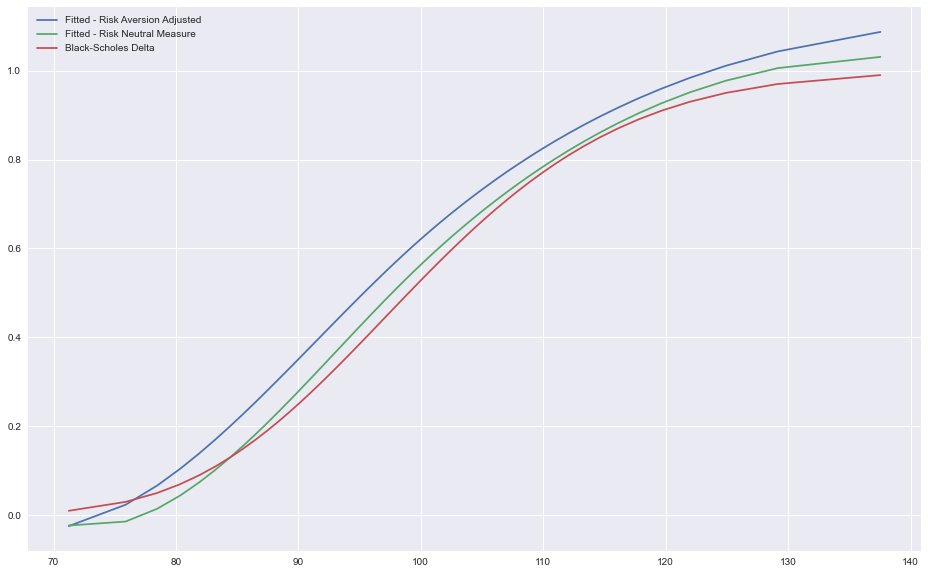

In [19]:
plt.figure(figsize=[16,10])
plt.plot(sp, optimalPolicy_sp[1], label='Fitted - Risk Aversion Adjusted')
plt.plot(sp, optimalPolicyRN_sp[1], label='Fitted - Risk Neutral Measure')
plt.plot(sp, PriceEuroVanillaDelta(sp, K, 0.5, 0.0, sigma), label='Black-Scholes Delta')
plt.legend()

Optimization terminated successfully.
         Current function value: 4.861260
         Iterations: 10
         Function evaluations: 128
         Gradient evaluations: 16
Var Explained Full   = 52.4
Var Explained Single = 19.18
Var Explained BS     = 46.82


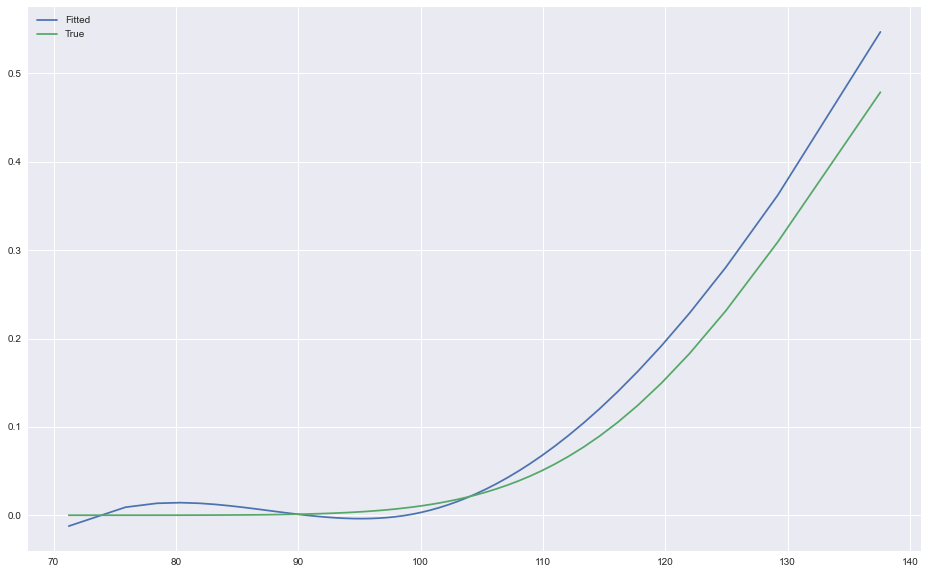

In [28]:
from scipy.optimize import fmin_bfgs

S0 = 100.0
dts = [0.0, 0.5, 1.0]
r = 0.0
sigma = 0.2
numPath = 200000

(S, W) = BlackScholesExactSimulationSobol(S0, dts, r, sigma, numPath)
S = np.array(S)

params = [0.5, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1]
K = 140.0
payoff = np.maximum(S[2]-K, 0.0)
optimalParams= fmin_bfgs(objVarianceByPoints, params, args=(S, payoff))

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S[1],sp)
aug_sp = (sp,sp,sp)
    
plt.figure(figsize=[16,10])
optimalPolicy = policyByPoints(optimalParams, aug_sp)
plt.plot(sp, optimalPolicy[1], label='Fitted')
plt.plot(sp, PriceEuroVanillaDelta(sp, K, 0.5, r, sigma), label='True')
plt.legend()

optimalPolicy = policyByPoints(optimalParams, S)
diff0 = S[1] - S[0]
diff1 = S[2] - S[1]
diffWhole= S[2] - S[0]
residual = payoff - optimalPolicy[0] * diff0 - optimalPolicy[1] * diff1
residualWhole = payoff - optimalPolicy[0] * diffWhole 
delta = PriceEuroVanillaDelta(S[1], K, 1.0, r, sigma)
residualDelta = payoff - optimalPolicy[0] * diff0 - delta * diff1

print("Var Explained Full   = " + str(round((1.0 - (np.var(residual) / np.var(payoff))) * 100.0, 2)))
print("Var Explained Single = " + str(round((1.0 - (np.var(residualWhole) / np.var(payoff))) * 100.0, 2)))
print("Var Explained BS     = " + str(round((1.0 - (np.var(residualDelta) / np.var(payoff))) * 100.0, 2)))

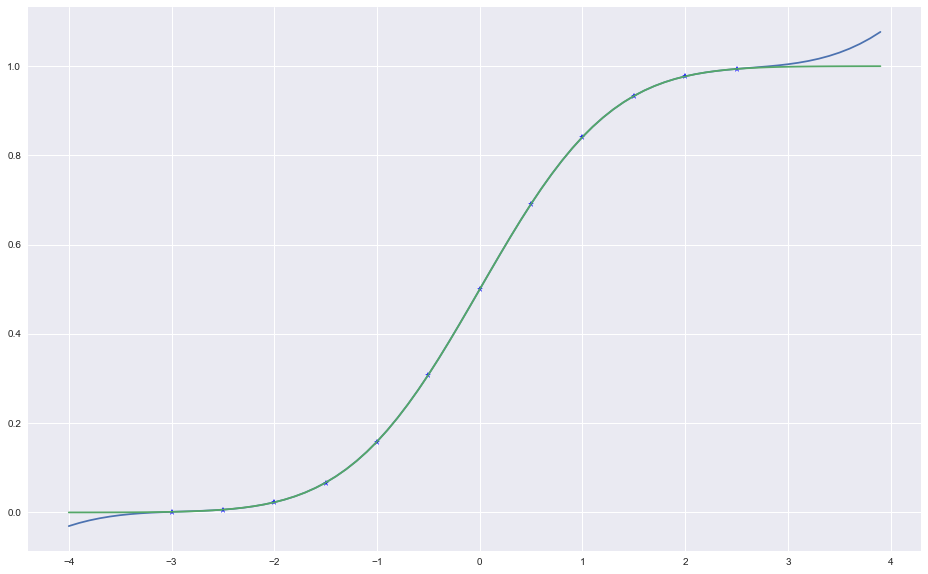

In [25]:
plt.figure(figsize=[16,10])

def f(x):
    return si.norm.cdf(x, 0.0, 1.0)

width = 3
sp = np.arange(-width-1, width+1, 0.1)
r = np.arange(-width, width, 0.5)

proj = interp1d(r, f(r), kind='cubic', fill_value='extrapolate')
plt.plot(sp,proj(sp))
plt.plot(r,f(r),'b*')
plt.plot(sp,f(sp))

In [ ]:

action.append(interp1d(p_tile, f(r), kind='cubic', fill_value='extrapolate')(S[1]))